In [228]:
import pandas as pd
import numpy as np
from DBapi import get_option_data, get_options_info, get_index_price
import matplotlib.pyplot as plt

## Выгрузка данных с платформы Deribit

Скачиваю через request все контракты по опционам с базовой валютой = currency_name:

In [229]:
contract_names=get_options_info()

Processing time: 0.24167108535766602


In [230]:
df=get_option_data(contract_names['instrument_name'])

Processing time: 55.65601897239685


In [232]:
df_plot=df.drop(['underlying_index', 'state',
       'settlement_price', 'open_interest', 'min_price', 'max_price',
       'last_price', 'interest_rate',
       'index_price', 'estimated_delivery_price',
       'change_id', 'bids', 'bid_iv', 'best_bid_amount',
       'best_ask_amount', 'asks', 'ask_iv', 'stats.volume',
       'stats.price_change', 'stats.low', 'stats.high', 'greeks.vega',
       'greeks.theta', 'greeks.rho', 'greeks.gamma', 'greeks.delta'], axis=1)

In [233]:
df_plot=df_plot.merge(contract_names[['instrument_name','expiration_timestamp']])

df_plot['strike'] = df_plot.instrument_name.map(lambda x: int(x.split('-')[2]))
df_plot['type'] = df_plot.instrument_name.map(lambda x: x.split('-')[3])
df_plot=df_plot.rename(columns={'expiration_timestamp':'date_strike'})

In [234]:
df_plot.date_strike.unique()

array(['2022-11-11', '2022-11-12', '2022-11-18', '2022-11-25',
       '2022-12-02', '2022-12-30', '2023-01-27', '2023-03-31',
       '2023-06-30', '2023-09-29'], dtype=object)

## Построение улыбки волатильности на данных, рассчитанных дерибитом

Замечание: волатильность для call и put контрактов идентичны

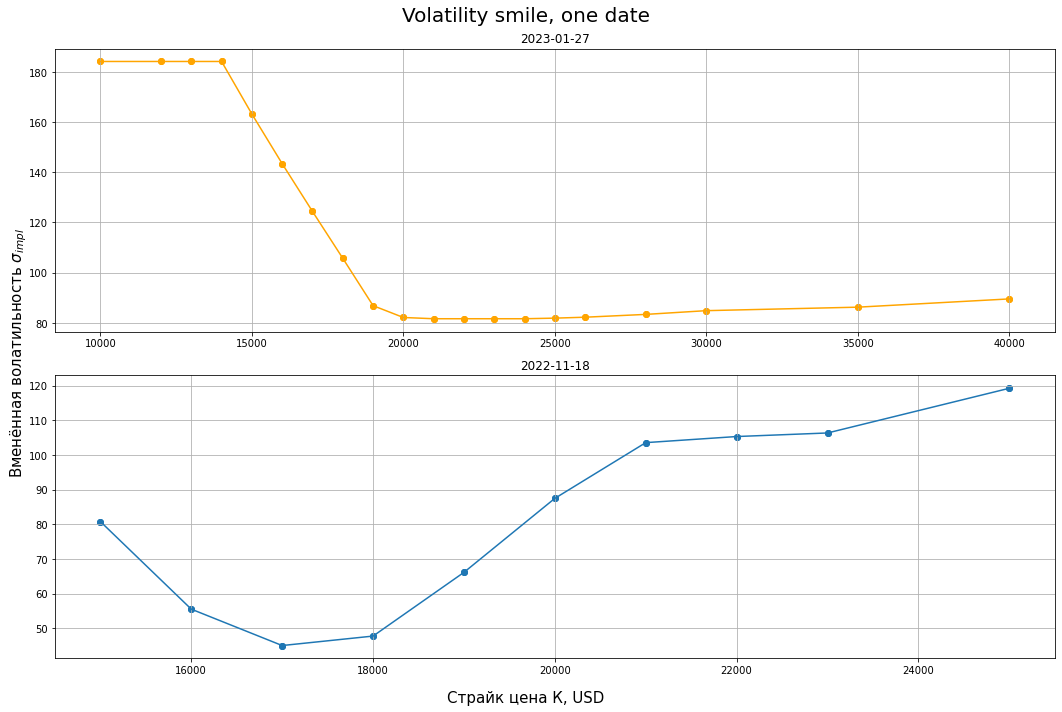

In [235]:
dates=['2023-01-27','2022-11-18']
fig, ax = plt.subplots(2,figsize=(15,10),sharex=False)
ax[0].scatter(x='strike',y='mark_iv',data=df_plot.query("(date_strike==@dates[0])&(mark_iv<mark_iv.quantile(0.95))"),\
              color='orange')
ax[0].plot(df_plot.query("(date_strike==@dates[0])&(mark_iv<mark_iv.quantile(0.95))").strike,\
           df_plot.query("(date_strike==@dates[0])&(mark_iv<mark_iv.quantile(0.95))").mark_iv,\
           color='orange')
ax[0].set_title(f'{dates[0]}')
ax[0].grid()

ax[1].scatter(x='strike',y='mark_iv',data=df_plot.query("(date_strike==@dates[1])&(mark_iv<mark_iv.quantile(0.95))"))
ax[1].plot(df_plot.query("(date_strike==@dates[1])&(mark_iv<mark_iv.quantile(0.95))").strike,\
           df_plot.query("(date_strike==@dates[1])&(mark_iv<mark_iv.quantile(0.95))").mark_iv)
ax[1].set_title(f'{dates[1]}')
ax[1].grid()
fig.supylabel('Вменённая волатильность $\sigma_{impl}$',fontsize=15)
fig.supxlabel('Страйк цена К, USD',fontsize=15)
fig.suptitle('Volatility smile, one date',fontsize=20)
plt.rcParams["figure.autolayout"] = True
plt.show()

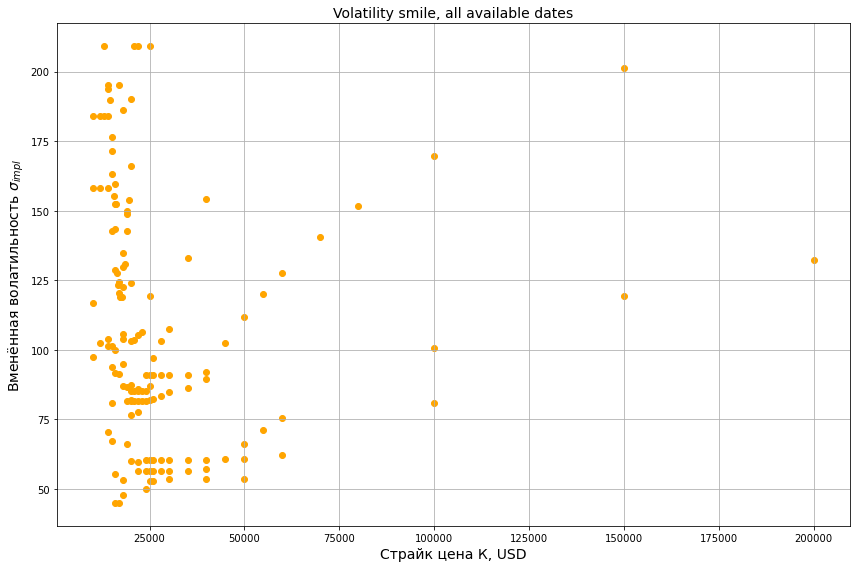

In [236]:
fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(x='strike',y='mark_iv',data=df_plot.query("(type=='C')&(mark_iv<mark_iv.quantile(0.95))"), color='orange')
#plt.xticks(range(10000, 100000, 10000))
#plt.yticks(range(20,150,20))
plt.grid()
plt.rcParams["figure.autolayout"] = True
plt.xlabel('Страйк цена К, USD',fontsize =14)
plt.ylabel('Вменённая волатильность $\sigma_{impl}$',fontsize =14)
plt.title('Volatility smile, all available dates',fontsize =14)
plt.show()

## Построение улыбки волатильности посредством модели БШМ

Формула БШМ вычисления цены call опциона:

$$C = SN(d_{1})-N(d_{2})Ke^{-rT}$$
где
$$d_{1} = \frac{ln(\frac{S}{K})+(r+\frac{\sigma^2}{2})T}{\sigma \sqrt{T}}$$
$$d_{2} = \frac{ln(\frac{S}{K})+(r-\frac{\sigma^2}{2})T}{\sigma \sqrt{T}}=d_{1}-\sigma \sqrt{T}$$

#### Первый способ: итеративный (Brute Force)

Суть алгоритма в мимнимизации разности между решением уравнения БШМ и наблюдаемой цены: $\mid C(\sigma)-C_{observed} \mid \to min_{\sigma >0}$

In [237]:
import math as m
from time import time
from scipy import stats
import numpy as np
from scipy.optimize import minimize

N_cdf=stats.norm.cdf

In [238]:
#Решение уравнения БШМ
def bsm_call(S,K,T,r,sigma):
    S=float(S)
    d1=(m.log(S/K)+(r+(sigma**2)/2)*T)/(sigma*m.sqrt(T))
    d2=d1-sigma*m.sqrt(T)
    #print(sigma)
    #print(d1,'  ',d2)
    #print(S*N_cdf(d1,0.,1.),'  ',K*m.exp(-r*T)*N_cdf(d2,0.,1.))
    return(S*N_cdf(d1,0.,1.)-K*m.exp(-r*T)*N_cdf(d2,0.,1.))

Здесь eps = $\epsilon$ - невязка  
Оптимизируем по методу Нелдера — Мида (симплекс-метод). Метод интересен, поскольку не использует градиенты функций

In [239]:
#Прогонка по параметрам
def brute_force(S,K,T,r,observed_price,eps=1e-3):
    def diff_prices(sigma):
        return abs(bsm_call(S,K,T,r,sigma)-observed_price)
    res=minimize(diff_prices, x0=1., method='nelder-mead',
                   options={'xatol': eps, 'disp': False})
    return res.x[0]

Проверка сходимости решений:

In [240]:
observed_price = 16.3

S=100.
K=115.
T=1.
r=0.05

sigma=0.5

print("Option price through BSM is %.6f" % (bsm_call(S,K,T,r,sigma)))
print("Price volatility through Brute Force is %.6f" % (brute_force(S,K,T,r,observed_price)))

Option price through BSM is 16.297592
Price volatility through Brute Force is 0.500049


In [241]:
df_plot.date_strike.unique()

array(['2022-11-11', '2022-11-12', '2022-11-18', '2022-11-25',
       '2022-12-02', '2022-12-30', '2023-01-27', '2023-03-31',
       '2023-06-30', '2023-09-29'], dtype=object)

In [277]:
import datetime as dt
date='2022-11-18'
opt_type='C'
df_bsm_vol=df_plot.drop('timestamp',axis=1)
df_bsm_vol=df_bsm_vol.query("(date_strike==@date)&(type==@opt_type)")
#df_bsm_vol['T_strike']=(pd.to_datetime(df_bsm_vol.date_strike)-dt.datetime.now()).dt.days/365
df_bsm_vol['date_strike']=df_bsm_vol.date_strike.map(lambda x: dt.date(int(x[:4]), int(x[5:7]), int(x[-2:])) )
df_bsm_vol['T_strike']=(df_bsm_vol.date_strike-dt.datetime.today().date()).dt.days / 365

In [278]:
df_bsm_vol['mark_price']=df_bsm_vol['mark_price']*df_bsm_vol['underlying_price']
df_bsm_vol['BSM_iv']=df_bsm_vol.apply(lambda x: 100*brute_force(S=x.underlying_price, K=x.strike, T=x.T_strike, \
                                                    r=0.03, observed_price=x.mark_price), axis=1)
df_bsm_vol['BSM_price']=df_bsm_vol.apply(lambda x: bsm_call(S=x.underlying_price, K=x.strike, T=x.T_strike, \
                                                    r=0.03, sigma=x.mark_iv/100), axis=1)

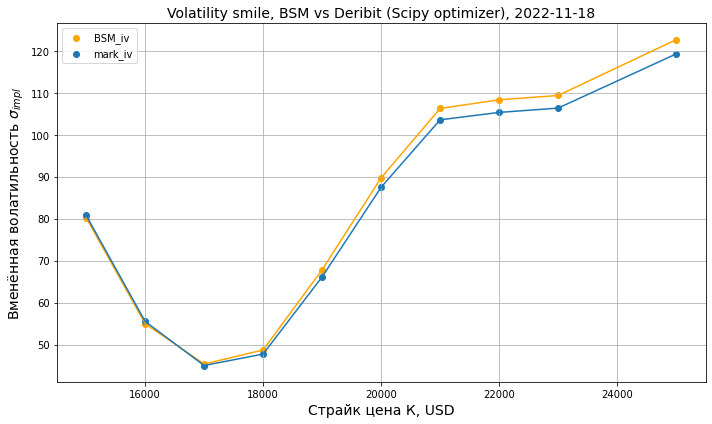

In [279]:
fig,ax=plt.subplots(figsize=(10,6))
ax.scatter(x='strike',y='BSM_iv',color='orange',data=df_bsm_vol)
ax.plot(df_bsm_vol.strike,df_bsm_vol.BSM_iv,color='orange')

ax.scatter(x='strike',y='mark_iv',data=df_bsm_vol)
ax.plot(df_bsm_vol.strike,df_bsm_vol.mark_iv)
ax.grid()
ax.legend()
plt.rcParams["figure.autolayout"] = True
plt.xlabel('Страйк цена К, USD',fontsize =14)
plt.ylabel('Вменённая волатильность $\sigma_{impl}$',fontsize =14)
plt.title(f'Volatility smile, BSM vs Deribit (Scipy optimizer), {date}',fontsize =14)
plt.show()

#### Второй способ: Newton Raphson Algorithm 

Алгоритм Ньютона-Рафсона часто используется для численного расчёта вменённой волатильности. Заключается в выполнении ряда шагов:
1) Задаём функцию $f(x)$, для которой ищем решение уравнения $f(x)=0$  
2) Задаём первый корень $x_{1}$ наугад, полагаясь на интуицию  
3) Ищем следующий корень как $x_{n+1}=x_{n}-\frac{f(x_{n})}{f^{\prime}(x_{n})}$  
4) Продолжаем итерацию до тех пора, пока ошибка больше невязки: $\mid f(x_{n}) \mid < \epsilon$

Применяя к нашей задаче алгоритм примет вид:
1) $f(\sigma)=C(\sigma)-C_{observed}$  
2) Задаём значение "по интуиции" $\sigma_{0}$  
3) Итерируем по схеме: $$\sigma_{n+1}=\sigma_{n}-\frac{C(\sigma)-C_{observed}}{\frac{\partial C(\sigma)}{\partial \sigma}}$$
4) Прерываем алгоритм когда $\mid C(\sigma)-C_{observed}\mid<\epsilon$

Вычисляя производную, известную также как грек "вега" получаем:
$$
Vega=\frac{\partial C(\sigma)}{\partial \sigma} = S\sqrt{T}N^{\prime}(d_{1})
$$
здесь $N^{\prime}(x)=\phi(x)$ - плотность вероятности нормального распределения

In [245]:
N_pdf=stats.norm.pdf

In [246]:
def vega(S,K,T,r,sigma):
    d1=(m.log(S/K)+(r+(sigma**2)/2)*T)/(sigma*m.sqrt(T))
    #print(d1,' ',N_pdf(d1))
    return S*m.sqrt(T)*N_pdf(d1)

In [247]:
def NR_vol(S,K,T,r, observed_price, eps=1e-4, start_sigma=1.\
           ,max_iterations=100):
    sigma=start_sigma
    for i in range(max_iterations):
        diff=bsm_call(S,K,T,r,sigma)-observed_price
        if abs(diff)<eps:
            #print(f'break on {i} iteration')
            #print(diff)
            #print(bsm_call(S,K,T,r,sigma))
            return sigma
        sigma=sigma-diff/vega(S,K,T,r,sigma)

In [248]:
observed_price = 16.3

S=100.
K=115.
T=1.
r=0.05

sigma=0.5

print("Option price through BSM is %.6f" % (bsm_call(S,K,T,r,sigma)))
print("Price volatility through NR is %.6f" % (NR_vol(S,K,T,r,observed_price)))

Option price through BSM is 16.297592
Price volatility through NR is 0.500061


Ньютон-Рафсон даёт такие же значения, как и Нелдера — Мида

In [249]:
df_plot.date_strike.unique()

array(['2022-11-11', '2022-11-12', '2022-11-18', '2022-11-25',
       '2022-12-02', '2022-12-30', '2023-01-27', '2023-03-31',
       '2023-06-30', '2023-09-29'], dtype=object)

In [265]:
import datetime as dt
date='2022-11-18'
opt_type='C'
df_bsm_vol=df_plot.drop('timestamp',axis=1)
df_bsm_vol=df_bsm_vol.query("(date_strike==@date)&(type==@opt_type)")
#df_bsm_vol['T_strike']=(pd.to_datetime(df_bsm_vol.date_strike)-dt.datetime.now()).dt.days/365
df_bsm_vol['date_strike']=df_bsm_vol.date_strike.map(lambda x: dt.date(int(x[:4]), int(x[5:7]), int(x[-2:])) )
df_bsm_vol['T_strike']=(df_bsm_vol.date_strike-dt.datetime.today().date()).dt.days / 365

df_bsm_vol['mark_price']=df_bsm_vol['mark_price']*df_bsm_vol['underlying_price']
df_bsm_vol['BSM_iv']=df_bsm_vol.apply(lambda x: 100*NR_vol(S=x.underlying_price, K=x.strike, T=x.T_strike, \
                                                    r=0.05, observed_price=x.mark_price), axis=1)
df_bsm_vol['BSM_price']=df_bsm_vol.apply(lambda x: bsm_call(S=x.underlying_price, K=x.strike, T=x.T_strike, \
                                                    r=0.05, sigma=x.mark_iv/100), axis=1)

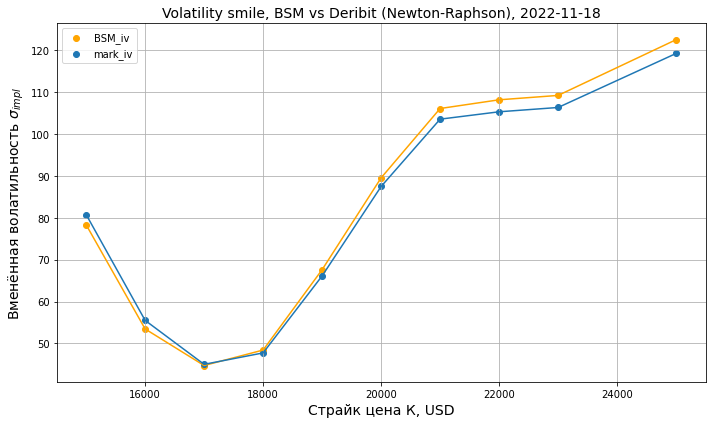

In [267]:
fig,ax=plt.subplots(figsize=(10,6))
ax.scatter(x='strike',y='BSM_iv',color='orange',data=df_bsm_vol)
ax.plot(df_bsm_vol.strike,df_bsm_vol.BSM_iv,color='orange')

ax.scatter(x='strike',y='mark_iv',data=df_bsm_vol)
ax.plot(df_bsm_vol.strike,df_bsm_vol.mark_iv)
ax.grid()
ax.legend()
plt.rcParams["figure.autolayout"] = True
plt.xlabel('Страйк цена К, USD',fontsize =14)
plt.ylabel('Вменённая волатильность $\sigma_{impl}$',fontsize =14)
plt.title(f'Volatility smile, BSM vs Deribit (Newton-Raphson), {date}',fontsize =14)
plt.show()